In [139]:
import torch
import torch.nn as nn
from torch import tensor
from PIL import Image
from torch.utils.data import DataLoader
from pathlib import Path
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

## Helpers

In [140]:
def load_image(infilename):
    img = Image.open(infilename)
    img.load()
    data = np.asarray(img, dtype=np.int32)
    return data


def get_num_tensors(path):
    nums = sorted(list((path).glob('*.png')))
    num_tensors = [tensor(load_image(o)) for o in nums]
    stacked_num = torch.stack(num_tensors).float() / 255
    return stacked_num


def get_nums_tensors(root_path, nums=[3, 7]):
    stacked_train_tensors = []
    stacked_valid_tensors = []
    for num in nums:
        stacked_train_tensors.append(get_num_tensors(path / 'train' / str(num)))
        stacked_valid_tensors.append(get_num_tensors(path / 'valid' / str(num)))
    return stacked_train_tensors, stacked_valid_tensors


def tensors2dset(stacked_tensors):
    x = torch.cat(stacked_tensors).view(-1, 28 * 28)
    # assumes that we have only 2 levels of values in y (1 and 0)
    y = [i for i, sublist in enumerate(stacked_tensors) for item in sublist]
    y = tensor(y).unsqueeze(1)
    return x, y


def get_dsets(root_path, nums=[3, 7]):
    stacked_train_tensors, stacked_valid_tensors = get_nums_tensors(root_path, nums)
    train_x, train_y = tensors2dset(stacked_train_tensors)
    valid_x, valid_y = tensors2dset(stacked_valid_tensors)

    train_dset = list(zip(train_x, train_y))
    valid_dset = list(zip(valid_x, valid_y))
    return train_dset, valid_dset


## Path

In [141]:
path = Path('data')

## Callbacks, learner

In [142]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets == 1, 1 - predictions, predictions).mean()


class BasicOptim:
    def __init__(self, params, lr):
        self.params, self.lr = list(params), lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds > 0.5) == yb
    return correct.float().mean()


def validate_epoch(model, valid_dl):
    model.eval()
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    model.train()
    return round(torch.stack(accs).mean().item(), 4)


# callbacks
class Callback():
    def begin_fit(self):
        return True

    def after_fit(self): return True

    def begin_epoch(self, epoch):
        self.epoch = epoch
        return True

    def begin_validate(self): return True

    def after_epoch(self): return True

    def begin_batch(self, xb, yb):
        self.xb, self.yb = xb, yb
        return True

    def after_loss(self, loss):
        self.loss = loss
        return True

    def after_backward(self): return True

    def after_step(self): return True


class BatchCounter(Callback):
    def begin_epoch(self, epoch):
        self.epoch = epoch
        self.batch_counter = 1
        return True

    def after_step(self):
        self.batch_counter += 1
        if self.batch_counter % 200 == 0: print(f'Batch {self.batch_counter} completed')
        return True


class TimeCheck(Callback):
    def begin_fit(self):
        self.epoch_counter = 1
        return True

    def begin_epoch(self, epoch):
        self.epoch = epoch
        print(f'Epoch {self.epoch_counter} started at {time.strftime("%H:%M:%S", time.gmtime())}')
        self.epoch_counter += 1
        return True


class PrintLoss(Callback):
    def after_epoch(self):
        print(f'Loss train: {round(self.loss.item(), 4)}')
        return True


class PrintValidLoss(Callback):
    def __init__(self):
        self.in_train = True

    def begin_validate(self):
        self.in_train = False
        self.val_losses = []
        return True

    def begin_batch(self, xb, yb):
        if not self.in_train:
            super(PrintValidLoss, self).begin_batch(xb, yb)
        return True

    def after_loss(self, loss):
        if not self.in_train:
            self.val_losses.append(loss.item())
        return False

    def after_epoch(self):
        if not self.in_train:
            print(f'Loss valid: {self.val_losses}')
            self.in_train = True
        return True


class GetValAcc(Callback):
    def begin_fit(self):
        self.in_train = True
        return True

    def batch_accuracy(self, xb, yb):
        xb = self.learn.model(xb)
        preds = xb.sigmoid()
        correct = (preds > 0.5) == yb
        return correct.float().mean().item()

    def begin_validate(self):
        self.in_train = False
        self.accs = []
        return True

    def begin_batch(self, xb, yb):
        if not self.in_train:
            acc = self.batch_accuracy(xb, yb)
            self.accs.append(acc)
        return True

    def after_epoch(self):
        if not self.in_train:
            print(f'Valid accuracy: {round(np.mean(self.accs), 4)}')
            self.in_train = True
        return True


def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds > 0.5) == yb
    return correct.float().mean()


def validate_epoch(model, valid_dl):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)


class CallbackHandler():
    def __init__(self, cbs=None):
        self.cbs = cbs if cbs else []

    def set_learn(self, learn):
        self.learn = learn
        for cb in self.cbs:
            cb.learn = self.learn

    def begin_fit(self):
        self.in_train = True
        self.learn.stop = False
        res = True
        for cb in self.cbs: res = res and cb.begin_fit()
        return res

    def after_fit(self):
        res = not self.in_train
        for cb in self.cbs: res = res and cb.after_fit()
        return res

    def begin_epoch(self, epoch):
        self.learn.model.train()
        self.in_train = True
        res = True
        for cb in self.cbs: res = res and cb.begin_epoch(epoch)
        return res

    def begin_validate(self):
        self.learn.model.eval()
        self.in_train = False
        res = True
        for cb in self.cbs: res = res and cb.begin_validate()
        return res

    def after_epoch(self):
        res = True
        for cb in self.cbs: res = res and cb.after_epoch()
        return res

    def begin_batch(self, xb, yb):
        res = True
        for cb in self.cbs: res = res and cb.begin_batch(xb, yb)
        return res

    def after_loss(self, loss):
        res = self.in_train
        for cb in self.cbs:
            res = res and cb.after_loss(loss)
        return res

    def after_backward(self):
        res = True
        for cb in self.cbs: res = res and cb.after_backward()
        return res

    def after_step(self):
        res = True
        for cb in self.cbs: res = res and cb.after_step()
        return res

    def do_stop(self):
        try:
            return self.learn.stop
        finally:
            self.learn.stop = False


def one_batch(xb, yb, cb, learn):
    if not cb.begin_batch(xb, yb): return
    loss = cb.learn.loss_func(cb.learn.model(xb), yb)
    if not cb.after_loss(loss): return
    loss.backward()
    if cb.after_backward(): cb.learn.opt.step()
    if cb.after_step(): cb.learn.opt.zero_grad()


def all_batches(dl, cb, learn):
    for xb, yb in dl:
        one_batch(xb, yb, cb, learn)
        if cb.do_stop(): return


def fit(epochs, learn):
    if not learn.cb.begin_fit(): return
    for epoch in range(epochs):
        if not learn.cb.begin_epoch(epoch): continue
        all_batches(learn.train_dl, learn.cb, learn)  ###

        if learn.cb.begin_validate():
            with torch.no_grad(): all_batches(learn.valid_dl, learn.cb, learn)
        if learn.cb.do_stop() or not learn.cb.after_epoch(): break
    learn.cb.after_fit()


class Learner:
    def __init__(self, model, loss_func, opt, train_dl, valid_dl, cb):
        self.model = model
        self.loss_func = loss_func
        self.opt = opt
        self.train_dl = train_dl
        self.valid_dl = valid_dl
        self.cb = cb
        self.cb.set_learn(self)


## Data, model

In [143]:
train_dset, valid_dset = get_dsets(path)

dl = DataLoader(train_dset, batch_size=256)
valid_dl = DataLoader(valid_dset, batch_size=256)

simple_net = nn.Sequential(
    nn.Linear(28 * 28, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

## Helpers lr finder

In [144]:
def annealing_linear(start, end, pct: float):
    "Linearly anneal from `start` to `end` as pct goes from 0.0 to 1.0."
    return start + pct * (end - start)

annealing_linear(0.0001, 2.0, 0.1)

0.20009

In [145]:
def annealing_exp(start, end, pct: float):
    "Exponentially anneal from `start` to `end` as pct goes from 0.0 to 1.0."
    return start * (end / start) ** pct

annealing_exp(0.0001, 2.0, 0.1)

0.00026921732181969566

In [146]:
def annealing_no(start, end, pct: float):
    "No annealing, always return `start`."
    return

def is_tuple(x) -> bool: return isinstance(x, tuple)


def is_listy(x) -> bool: return isinstance(x, (tuple, list))

In [147]:
class Scheduler():
    "Used to \"step\" from start,end (`vals`) over `n_iter` iterations on a schedule defined by `func`"

    def __init__(self, vals, n_iter: int, func=None):
        self.start, self.end = (vals[0], vals[1]) if is_tuple(vals) else (vals, 0)
        self.n_iter = max(1, n_iter)
        if func is None:
            self.func = annealing_linear if is_tuple(vals) else annealing_no
        else:
            self.func = func
        self.n = 0

    def restart(self):
        self.n = 0

    def step(self):
        "Return next value along annealed schedule."
        self.n += 1
        return self.func(self.start, self.end, self.n / self.n_iter)

    @property
    def is_done(self) -> bool:
        "Return `True` if schedule completed."
        return self.n >= self.n_iter
    
sched=Scheduler((0.001, 1.0), 20, annealing_exp)
sched.step()

0.0014125375446227544

In [148]:
sched.step()

0.00199526231496888

In [149]:
class LRFinder(Callback):
    "Causes `learn` to go on a mock training from `start_lr` to `end_lr` for `num_it` iterations."

    def __init__(self, start_lr: float = 1e-7, end_lr: float = 10, num_it: int = 100,
                 stop_div: bool = True, annealing_func=annealing_linear, beta=.98):
        self.stop_div = stop_div
        self.sched = Scheduler((start_lr, end_lr), num_it, annealing_func)
        self.lrs = []
        self.losses = []
        self.beta=beta
        self.avg_loss=0

    def begin_fit(self):
        "Initialize optimizer and learner hyperparameters."
        # setattr(pbar, 'clean_on_interrupt', True)
        # self.learn.save('tmp')
        self.iteration = 1
        self.opt = self.learn.opt
        self.opt.lr = self.sched.start
        self.stop, self.best_loss = False, 0.
        return {'skip_validate': True}

    def after_loss(self, loss, **kwargs):
        "Determine if loss has runaway and we should stop."
        self.avg_loss = self.beta * self.avg_loss + (1-self.beta) *loss.item()
        smooth_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        
        if self.iteration == 0 or smooth_loss < self.best_loss: self.best_loss = smooth_loss
        self.lrs.append(self.opt.lr)
        self.losses.append(smooth_loss)
        self.opt.lr = self.sched.step()
        if self.sched.is_done or (self.stop_div and (smooth_loss > 4 * self.best_loss or torch.isnan(smooth_loss))):
            # We use the smoothed loss to decide on the stopping since it's less shaky.
            if not self.stop: self.stop = self.iteration
            return False
        self.iteration += 1
        return True

    def after_epoch(self, **kwargs):
        if self.stop: return False

    def after_fit(self, **kwargs):
        "Cleanup learn model weights disturbed during LRFinder exploration."
        # self.learn.load('tmp', purge=False)
        if hasattr(self.learn.model, 'reset'): self.learn.model.reset()
        # for cb in self.cb:
        #     if hasattr(cb, 'reset'): cb.reset()
        print('LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.')
        df_lr_loss=pd.DataFrame({'loss':self.losses[10:-5], 'lr':np.log(self.lrs[10:-5])})
        df_lr_loss=df_lr_loss.set_index('lr')
        df_lr_loss.loss.plot()
        print(self.losses[10:-5])
        print(self.lrs[10:-5])
#         plt.plot(np.log10(self.lrs), self.losses)
        # total_batches = epoch * num_batch
        # if total_batches - self.stop > 10:
        #     print(
        #         f"Best loss at batch #{self.stop}/{total_batches}, may consider .plot(skip_end={total_batches - self.stop + 3})")


In [150]:
def lr_find(start_lr=1e-7, end_lr=10, num_it: int = 49, stop_div: bool = True, wd: float = None, 
            annealing_func=annealing_exp):
    "Explore lr from `start_lr` to `end_lr` over `num_it` iterations in `learn`. If `stop_div`, stops when loss diverges."
    # start_lr = learn.lr_range(start_lr)
    # start_lr = np.array(start_lr) if is_listy(start_lr) else start_lr
    # end_lr = learn.lr_range(end_lr)
    # end_lr = np.array(end_lr) if is_listy(end_lr) else end_lr
    opt = BasicOptim(simple_net.parameters(), start_lr)
    cb = LRFinder(start_lr, end_lr, num_it, stop_div, annealing_func=annealing_func)
    # todo make dynamic
    learner = Learner(simple_net, mnist_loss, opt, dl, valid_dl, cb=CallbackHandler([cb]))
    epochs = int(np.ceil(num_it / len(learner.train_dl)))
    fit(epochs, learn=learner)


#run

lr = 1e-3
opt = BasicOptim(simple_net.parameters(), lr)


# fit(10, learn=learner, cb=CallbackHandler([BatchCounter(), TimeCheck(), PrintLoss(), PrintValidLoss()]))
# fit(10, learn=learner, cb=CallbackHandler([BatchCounter(), TimeCheck(), PrintLoss(), GetValAcc()]))
# fit(10, learn=learner)
#lr_find(learner, start_lr=1e-7, end_lr=10, num_it = 100, stop_div = True, wd = None)

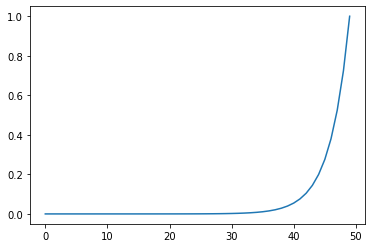

In [165]:
sched = Scheduler((1e-7, 1), n_iter=50, func=annealing_exp)
lrs=[sched.step() for _ in range(50)]
plt.plot(lrs)

In [170]:
np.array(lrs)

array([1.38038426e-07, 1.90546072e-07, 2.63026799e-07, 3.63078055e-07,
       5.01187234e-07, 6.91830971e-07, 9.54992586e-07, 1.31825674e-06,
       1.81970086e-06, 2.51188643e-06, 3.46736850e-06, 4.78630092e-06,
       6.60693448e-06, 9.12010839e-06, 1.25892541e-05, 1.73780083e-05,
       2.39883292e-05, 3.31131121e-05, 4.57088190e-05, 6.30957344e-05,
       8.70963590e-05, 1.20226443e-04, 1.65958691e-04, 2.29086765e-04,
       3.16227766e-04, 4.36515832e-04, 6.02559586e-04, 8.31763771e-04,
       1.14815362e-03, 1.58489319e-03, 2.18776162e-03, 3.01995172e-03,
       4.16869383e-03, 5.75439937e-03, 7.94328235e-03, 1.09647820e-02,
       1.51356125e-02, 2.08929613e-02, 2.88403150e-02, 3.98107171e-02,
       5.49540874e-02, 7.58577575e-02, 1.04712855e-01, 1.44543977e-01,
       1.99526231e-01, 2.75422870e-01, 3.80189396e-01, 5.24807460e-01,
       7.24435960e-01, 1.00000000e+00])

In [169]:
np.log(lrs)

array([-15.79573374, -15.47337182, -15.15100991, -14.828648  ,
       -14.50628609, -14.18392417, -13.86156226, -13.53920035,
       -13.21683843, -12.89447652, -12.57211461, -12.24975269,
       -11.92739078, -11.60502887, -11.28266696, -10.96030504,
       -10.63794313, -10.31558122,  -9.9932193 ,  -9.67085739,
        -9.34849548,  -9.02613356,  -8.70377165,  -8.38140974,
        -8.05904783,  -7.73668591,  -7.414324  ,  -7.09196209,
        -6.76960017,  -6.44723826,  -6.12487635,  -5.80251443,
        -5.48015252,  -5.15779061,  -4.8354287 ,  -4.51306678,
        -4.19070487,  -3.86834296,  -3.54598104,  -3.22361913,
        -2.90125722,  -2.5788953 ,  -2.25653339,  -1.93417148,
        -1.61180957,  -1.28944765,  -0.96708574,  -0.64472383,
        -0.32236191,   0.        ])

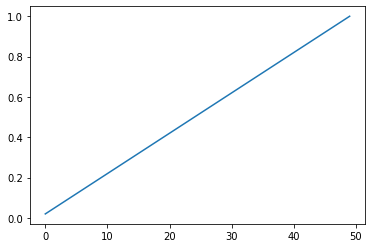

In [161]:
sched = Scheduler((1e-7, 1), n_iter=50, func=annealing_linear)
lrs=[sched.step() for _ in range(50)]
plt.plot(lrs)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
[4.675193958081134, 5.052031701748948, 5.419076684540981, 5.7798068914393035, 6.1353956033495916, 6.481178083252281, 6.818565794494492, 7.151490010115909, 7.4777759772018, 7.797935814484545, 8.11073138972928, 8.419218188202317, 8.720717623991186, 9.019495814302731, 9.376490467661604, 9.72565888046871, 10.066109727879935, 10.401002957859996, 10.728341268053228, 11.051252293606165, 11.36555188085553, 11.672257452430314, 11.974598991709497, 12.271470553955233, 12.561655037338712, 12.846571974834278, 13.124689735395576, 13.398516686632638, 13.666514120138602, 13.928289304578483, 14.185793030854162, 14.438339026793017, 14.68481390971312, 14.924655794227139]
[2.5118864315095806e-06, 3.4673685045253164e-06, 4.7863009232263826e-06, 6.606934480075961e-06, 9.120108393559101e-06, 1.258925411794167e-05, 1.7378008287493757e-05, 2.3988329190194914e-05, 3.3113112148259103e-05, 4.57088189614875e-05, 6.309573444801935e-05, 8.7

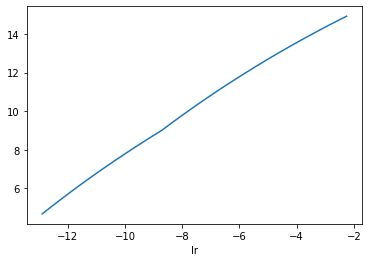

In [162]:
lr_find(start_lr=1e-7, end_lr=1, num_it=50, stop_div=True, wd=None)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
[4.675193958081134, 5.052031701748948, 5.419076684540981, 5.7798068914393035, 6.1353956033495916, 6.481178083252281, 6.818565794494492, 7.151490010115909, 7.4777759772018, 7.797935814484545, 8.11073138972928, 8.419218188202317, 8.720717623991186, 9.019495814302731, 9.376490467661604, 9.72565888046871, 10.066109727879935, 10.401002957859996, 10.728341268053228, 11.051252293606165, 11.36555188085553, 11.672257452430314, 11.974598991709497, 12.271470553955233, 12.561655037338712, 12.846571974834278, 13.124689735395576, 13.398516686632638, 13.666514120138602, 13.928289304578483, 14.185793030854162, 14.438339026793017, 14.68481390971312, 14.924655794227139]
[2.5118864315095806e-06, 3.4673685045253164e-06, 4.7863009232263826e-06, 6.606934480075961e-06, 9.120108393559101e-06, 1.258925411794167e-05, 1.7378008287493757e-05, 2.3988329190194914e-05, 3.3113112148259103e-05, 4.57088189614875e-05, 6.309573444801935e-05, 8.7

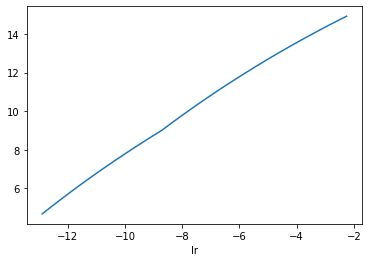

In [164]:
lr_find(start_lr=1e-7, end_lr=1, num_it=50, stop_div=True, wd=None, annealing_func=annealing_exp)